<a href="https://www.kaggle.com/code/yassinemharrek/brain-tumor-detection?scriptVersionId=138390599" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Brain Tumor Detection

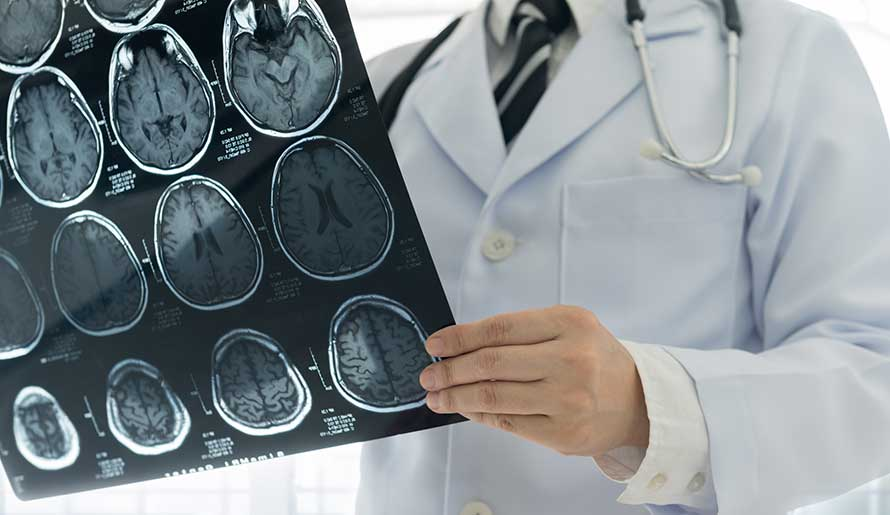

# 1. Business Understanding

This project aims to develop a BTD system from MRI (Magnetic Resonance Imaging) scans. This system will help clinicians to make an accurate diagnosis in order to improve the survival of patients.

# 2. Data Understanding

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import shutil
import glob
import pandas as pd

In [2]:
#Counting the number of images of the two classes ( Class 0 : No brain tumor , Class 1 : brain tumor)
df=pd.read_csv("/kaggle/input/brain-tumor/Brain Tumor.csv")
df.head(10)

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155
5,Image6,0,7.524109,607.395258,24.645390,0.214086,3.729886,14.471736,105.077882,0.421587,0.177736,0.598169,4.193146,0.976485,7.458341e-155
6,Image7,0,12.304413,922.746138,30.376737,0.128833,2.930095,8.969348,115.203118,0.320675,0.102832,0.532292,4.880320,0.974745,7.458341e-155
7,Image8,0,15.929474,1069.950248,32.710094,0.107658,2.484002,6.515889,94.874288,0.291321,0.084868,0.532262,4.242054,0.976774,7.458341e-155
8,Image9,0,19.921616,1166.120922,34.148513,0.094975,2.129173,4.905844,93.818920,0.272486,0.074248,0.526644,4.027167,0.974310,7.458341e-155
9,Image10,1,8.476196,1095.785127,33.102645,0.003002,4.365000,19.682514,72.588783,0.045685,0.002087,0.361432,4.590795,0.967830,7.458341e-155


In [3]:
df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

In [4]:
base_dir = '/kaggle/input/brain-tumor/Brain Tumor/Brain Tumor'


[(240, 240, 3), (240, 240, 3), (240, 240, 3), (240, 240, 3), (240, 240, 3), (240, 240, 3), (240, 240, 3), (240, 240, 3)]


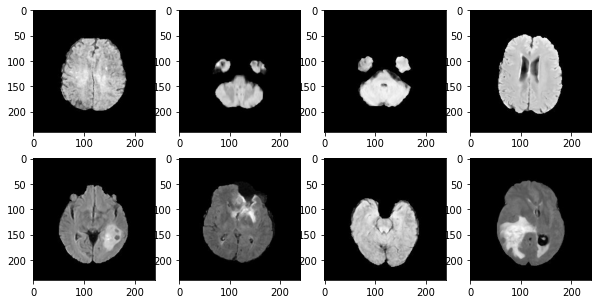

In [5]:
#Here we want to see some of the images
import matplotlib.pyplot as plt
import os

sub_class = os.listdir(base_dir)
shapes=[]
fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(base_dir,sub_class[e]))  
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    shapes.append(img.shape)

print(shapes)

# 3. Data preparation

In [6]:
#Before preprocessing our images we need to add the extensions to image column
def append_ext(fn):
    return fn+".jpg"

df['Image']=df['Image'].apply(append_ext)
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1.jpg,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2.jpg,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3.jpg,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4.jpg,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5.jpg,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


# 4. Modelling

In [7]:
#Assigning labels to the images using ImageDataGenerator from tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
df['Class'] = df['Class'].astype(str)


# Add our data-augmentation parameters to ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255.,
                                   validation_split=0.2,
                                   rotation_range = 40,
                                   horizontal_flip = True)

train_generator=datagen.flow_from_dataframe(
dataframe=df,
directory=base_dir,
x_col="Image",
y_col="Class",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(240,240))

validation_generator=datagen.flow_from_dataframe(
dataframe=df,
directory=base_dir,
x_col="Image",
y_col="Class",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(240,240))

Found 3010 validated image filenames belonging to 2 classes.
Found 752 validated image filenames belonging to 2 classes.


In [8]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-07-30 17:35:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   201MB/s    in 0.4s    

2023-07-30 17:35:43 (201 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (240, 240, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [10]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 13, 13, 768)


In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 119, 119, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 119, 119, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 119, 119, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [13]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            verbose = 2)

Epoch 1/20
95/95 - 79s - loss: 3.6484 - accuracy: 0.8023 - val_loss: 0.2177 - val_accuracy: 0.9295
Epoch 2/20
95/95 - 56s - loss: 0.3615 - accuracy: 0.8864 - val_loss: 0.1761 - val_accuracy: 0.9295
Epoch 3/20
95/95 - 57s - loss: 0.2369 - accuracy: 0.9050 - val_loss: 0.1610 - val_accuracy: 0.9402
Epoch 4/20
95/95 - 57s - loss: 0.1801 - accuracy: 0.9256 - val_loss: 0.1407 - val_accuracy: 0.9508
Epoch 5/20
95/95 - 56s - loss: 0.2097 - accuracy: 0.9153 - val_loss: 0.1514 - val_accuracy: 0.9535
Epoch 6/20
95/95 - 58s - loss: 0.1835 - accuracy: 0.9289 - val_loss: 0.1500 - val_accuracy: 0.9428
Epoch 7/20
95/95 - 58s - loss: 0.1456 - accuracy: 0.9432 - val_loss: 0.1688 - val_accuracy: 0.9388
Epoch 8/20
95/95 - 56s - loss: 0.1491 - accuracy: 0.9445 - val_loss: 0.1392 - val_accuracy: 0.9415
Epoch 9/20
95/95 - 56s - loss: 0.1856 - accuracy: 0.9282 - val_loss: 0.1043 - val_accuracy: 0.9628
Epoch 10/20
95/95 - 57s - loss: 0.1156 - accuracy: 0.9565 - val_loss: 0.1098 - val_accuracy: 0.9614
Epoch 11/

# 5. Evaluation

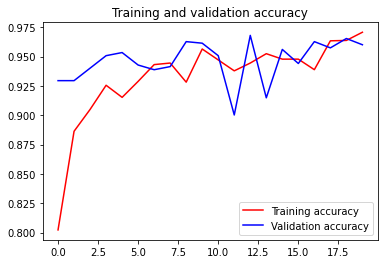

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# 6. Deployment

In [15]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

test_dir = '/kaggle/input/test-images'
fname = 'Sans titre2.jpg'
# predicting images
path=os.path.join(test_dir, fname)
img=load_img(path, target_size=(240, 240))
  
x=img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=10)
  
print(classes[0])
if classes[0]>0.5:
    print(fname + " have a brain tumor")
else:
    print(fname + " does not have a brain tumor")

[0.99977654]
Sans titre2.jpg have a brain tumor
